

#  Proyecto Integrado: Análisis de Ventas de Videojuegos (Ice)

**Autor:** [Anderson Muñoz]  
**Versión:** 1.0  

---

## 0. Introducción

- **Contexto:** La tienda online Ice vende videojuegos a nivel global. Se desea identificar patrones de éxito en los juegos para planear campañas publicitarias en 2017.  
- **Objetivo:** Analizar ventas históricas, reseñas, plataformas, géneros y clasificaciones ESRB para detectar tendencias y elaborar recomendaciones estratégicas.
  
   Este análisis permitirá optimizar estrategias de marketing y priorizar inversiones en plataformas y géneros con mayor potencial de ventas en 2017.
  
- **Estructura del Notebook:**  
  1. Carga de datos  
  2. Preparación de datos  
  3. Análisis exploratorio  
  4. Perfiles regionales  
  5. Pruebas de hipótesis
  6. Conclusiones generales  


---




## 1. Carga de datos y vista general

**Preguntas guía:**  
- ¿Cuántas filas y columnas tiene el dataset?  
- ¿Qué tipos de datos trae cada columna?  
- ¿Cuántos valores nulos hay por columna?  
- ¿Existen duplicados?  

**Métodos recomendados:**  
- `df.shape`, `df.head()`, `df.info()`  
- `df.isna().sum()` o `.mean()`  
- `df.duplicated().sum()`  

### Inicializacion

In [55]:
# Carga todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


In [56]:
df_games = pd.read_csv('games.csv')

### Panorama inicial de los datos

In [57]:
#Informacion general del DataFrame.
print('Informacion general del DF\n')
df_games.info()
print()
print('Estructura del DF:\n')
df_games.head()


Informacion general del DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

Estructura del DF:



,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [58]:
# Resumen del DF, muestra el tamaño, duplicados, y valores nulos
for name,df in [
    ('games',df_games)
]:
    nulls = df.isna().sum().sum() # Cuenta el total de valores nulos
    dups = df.duplicated().sum() # Cuenta las filas duplicadas
    print(f'{name}: shape = {df.shape},nulls={nulls},duplicates = {dups}')



games: shape = (16715, 11),nulls=22318,duplicates = 0


### Conclusión del panorama inicial

- El dataset contiene **16715 filas y 11 columnas**.  
- No hay duplicados exactos, aunque se revisará más adelante la existencia de juegos multi-plataforma.  
- Existen aproximadamente **22,318 valores nulos**, concentrados en:  
  - `critic_score` (~51%)  
  - `user_score` (~40%, incluye la categoría `'tbd'`)  
  - `rating` (~40%)  
  - `year_of_release` (1.5%)  
- La columna `year_of_release` debe convertirse a entero (`Int64`) porque representa un año.  
- La columna `user_score` requiere limpieza: convertir `'tbd'` a NA y luego a numérico (`float`).
- Los valores nulos en  `critic_score` y `user_score` seran manejados a posteriori.



### Preparacion de los datos

####  Renombrar columnas

In [59]:
# Cambia las columnas a minuscula
df_games.columns = df_games.columns.str.lower()

####  Conversión de tipos

In [60]:
# Cambia la columna 'year_of_release' a tipo int64
df_games['year_of_release'] = df_games['year_of_release'].astype('Int64')

In [61]:
# Reemplaza 'Tbd' con 'NAN'
df_games['user_score'] = df_games['user_score'].replace('tbd',np.nan)

# Convierte a tipo float
df_games['user_score'] = pd.to_numeric(df_games['user_score'],errors = 'coerce')

In [62]:
# Crea una columna nueva, con 'critic_score' dividida entre 10
df_games['critic_score_scaled'] = df_games['critic_score']/10

#### Manejo de valores ausentes

In [63]:
#Cuenta los nulos en la columna 'year_of_release'
print(df_games['year_of_release'].isna().sum())

# Elimina los NA de la columna 'year_of_release'
df_games = df_games.dropna(subset =['year_of_release']).copy()

269


In [64]:
# Cuenta los valores nulos en la columna 'rating'
print(df_games['rating'].isna().sum())

# Reemplaza los NaN de la columna 'rating' con 'unknown'
df_games['rating'] = df_games['rating'].fillna('unknown')

# vista rapida
df_games['rating'].head(5)

6678


0          E
1    unknown
2          E
3          E
4    unknown
Name: rating, dtype: object

**Nota técnica:**  
Después de eliminar los registros con `year_of_release` nulo, se creó una copia explícita del DataFrame con `.copy()`.  
Esto evita el warning `SettingWithCopyWarning` al añadir nuevas columnas y garantiza que las operaciones posteriores modifiquen el DataFrame original.


#### Crear columna de ventas totales

In [65]:
# Crea una columna con las ventas totales de todas las regiones
df_games['total_sales'] = (
    df_games['na_sales'] + 
    df_games['eu_sales'] +
    df_games['jp_sales'] +
    df_games['other_sales']
)

# Vista rapida
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_scaled,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,7.6,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,8.2,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,8.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,NaN,31.38


#### Duplicados y consistencia

In [66]:
# Revisa duplicados 
print(f'Existen filas duplicadas:{df_games.duplicated().sum()}')
print()
# Identifica juegos multiplataforma
print(f'juegos multiplaforma:\n{df_games["name"].value_counts().head(10)}')



Existen filas duplicadas:0

juegos multiplaforma:
name
Need for Speed: Most Wanted    12
Ratatouille                     9
FIFA 14                         9
LEGO Marvel Super Heroes        9
The LEGO Movie Videogame        8
Monopoly                        8
Cars                            8
LEGO Jurassic World             8
FIFA Soccer 13                  8
FIFA 15                         8
Name: count, dtype: int64


### Conclusiones – Preparación de datos

- **Renombrado de columnas:**  
  Todas las columnas se estandarizaron a minúsculas con formato `snake_case`.  
  Esto facilita la manipulación y asegura consistencia en el proyecto.  

- **Conversión de tipos:**  
  - `year_of_release` se convirtió a entero (`Int64`), ya que representa un año.  
  - `user_score` se limpió reemplazando `'tbd'` por `NaN` y luego convirtiéndose a `float`.  
  - `critic_score` se mantuvo como `float`, y además se creó una versión ajustada a escala 0–10 (`critic_score_scaled`) para compararla con `user_score`.  

- **Manejo de valores ausentes:**  
  - Se eliminaron las filas con `year_of_release` nulo (~1.5% del dataset), porque el año es clave para el análisis temporal.  
  - En `critic_score` y `user_score` se mantuvieron los valores nulos, para evitar imputaciones que distorsionen correlaciones.  
  - En `rating`, los nulos se reemplazaron por la categoría `"unknown"`, preservando los registros para el análisis regional.  

- **Columna de ventas totales:**  
  Se creó la columna `total_sales` como suma de ventas en todas las regiones (`na_sales + eu_sales + jp_sales + other_sales`).  
  Se mantuvo en tipo `float64` para conservar precisión en valores decimales.  

- **Duplicados y consistencia:**  
  - No se detectaron duplicados exactos en el dataset.  
  - Se identificaron juegos multi-plataforma y multi-año, considerados registros válidos y mantenidos.  

**En resumen**, el dataset quedó preparado para el análisis: columnas estandarizadas, tipos corregidos, valores ausentes tratados con justificación, y una métrica global (`total_sales`) lista para explorar patrones de ventas.

**Nota técnica:**  
Después de eliminar los registros con `year_of_release` nulo, se creó una copia explícita del DataFrame con `.copy()`.  
Esto evita el warning `SettingWithCopyWarning` al añadir nuevas columnas y garantiza que las operaciones posteriores modifiquen el DataFrame original.

---

## Analisis exploratorio (EDA)

#### Cuántos juegos fueron lanzados en diferentes años?

##### Lanazamientos por año (representatividad del periodo)

Objetivo: decidir la ventana temporal para modelar el 2017

Logica:

- Contar juegos por 'year_of_release'.
- Detectar caídas/ruido en años muy antiguos.
- Elegir una ventana reciente con suficiente volumen.



In [67]:
# Cuenta juegos por 'year_of_release'
games_per_year = (
    df_games['year_of_release']
    .value_counts()
    .sort_index()
    .reset_index()
)
games_per_year.columns = ['year_of_release','games_count']

# Visualizacion rapida
games_per_year.head(10)

,year_of_release,games_count
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


<function matplotlib.pyplot.show(close=None, block=None)>

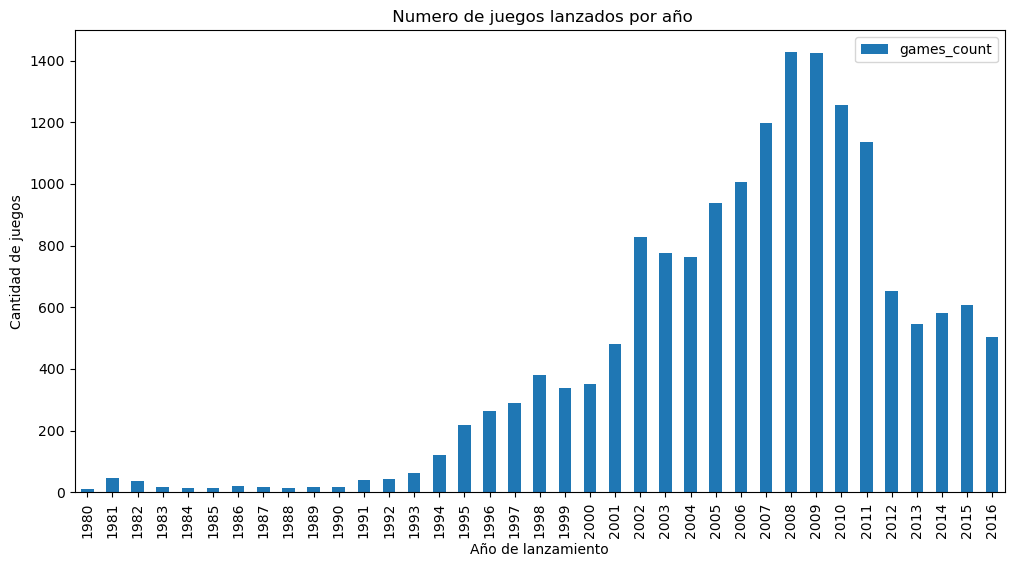

In [68]:
# Crea grafico de barras con el numero de juegos lanzados por año.
games_per_year.plot(
    x='year_of_release',
    y='games_count',
    kind='bar',
    figsize=(12,6),
    title= ' Numero de juegos lanzados por año'
)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de juegos')
plt.show

#### Conclusión – Lanzamientos por año

El número de lanzamientos creció de forma constante hasta 2008 y luego se estabilizó.  
A partir de 2012, el ritmo de lanzamientos representa un mercado más maduro, dominado por plataformas modernas (PS4, Xbox One, PC).  
Dado que los datos de 2016 parecen incompletos, se considerará el periodo **2012–2016** como base de análisis para modelar 2017.

---


#### Ciclo de vida por plataforma (aparecen -> pico -> declive)
Objetivo

- Entender que platraformas estan en crecimiento,maduras o en declive.

Logica

- Calcular ventas anuales por plataforma.
- Ordenar plataformas por *ventas totales* recientes y graficar top 6
- Identificar plataformas 'muertas'(sin ventas recientes).



In [69]:
# Filtra el rango representativo.
recent_games = df_games[df_games['year_of_release'] >= 2012]

In [70]:
# Agrupa y calcula las ventas totales por 'plataform' y 'year_of_release'
sales_per_platform = (
    recent_games
        .groupby(['platform','year_of_release'])['total_sales']
        .sum()
        .reset_index()
)

# Vista rapida
sales_per_platform.head()

,platform,year_of_release,total_sales
0,3DS,2012,51.36
1,3DS,2013,56.57
2,3DS,2014,43.76
3,3DS,2015,27.78
4,3DS,2016,15.14


In [71]:
# Selecciona las plataformas principales. 
top_platforms = (
    sales_per_platform
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
)

# Vista rapida
top_platforms

Index(['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU'], dtype='object', name='platform')

In [72]:
# Filtra las plataformas principales.
sales_top = sales_per_platform[sales_per_platform['platform'].isin(top_platforms)]

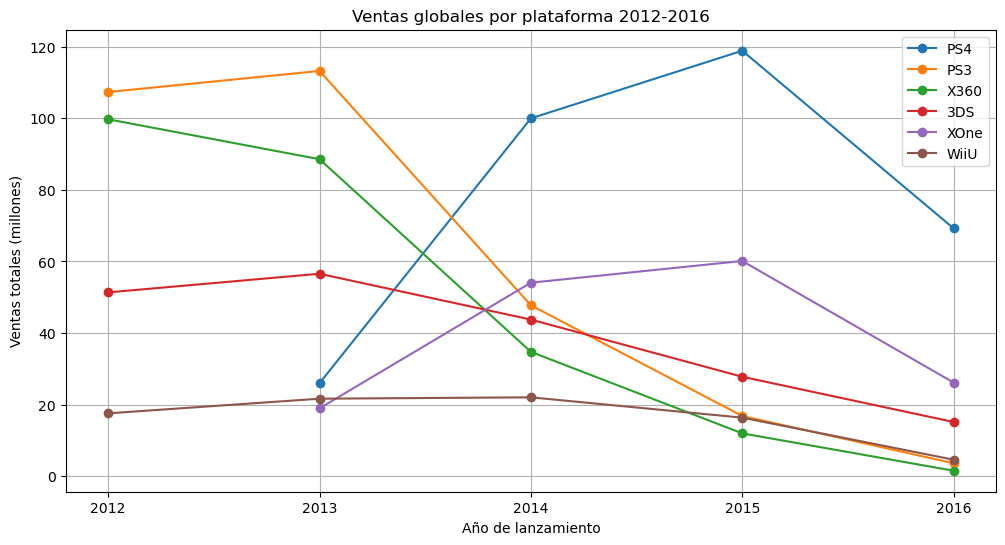

In [73]:
# Grafica la evolucion temporal
plt.figure(figsize=(12,6))
for platform in top_platforms:
    platform_data = sales_top[sales_top['platform'] == platform]
    plt.plot(platform_data['year_of_release'],
            platform_data['total_sales'],
            marker='o',
             label=platform
            )
plt.title('Ventas globales por plataforma 2012-2016')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas totales (millones)')
plt.legend()
plt.grid(True)
plt.xticks(sales_top['year_of_release'].unique().astype(int))
plt.show()


### Conclusión  – Ciclo de vida por plataforma

El análisis de ventas anuales por plataforma (2012–2016) revela los distintos momentos del ciclo de vida de cada consola:

- **PS4** muestra un fuerte crecimiento desde 2013, alcanzando su punto máximo en 2015. Esto refleja una etapa de expansión activa y consolidación en el mercado.  
- **XOne** también presenta una tendencia positiva durante el mismo periodo, consolidándose como una de las plataformas con mayor proyección hacia 2017.  
- **PC** (aunque no aparece en el gráfico) suele mantener ventas estables, representando una plataforma de presencia constante.  
- **PS3**, **X360**, **3DS** y **WiiU** muestran caídas pronunciadas a partir de 2013, evidenciando el final de su ciclo comercial y su reemplazo por consolas de nueva generación.  

En síntesis, las plataformas **PS4** y **XOne** se encuentran en crecimiento y son las más relevantes para el análisis y proyecciones de 2017, mientras que **PS3**, **X360**, **3DS** y **WiiU** se consideran en fase de declive o salida del mercado.

---


### Distribución de ventas por plataforma

Objetivo: 
- Evaluar el comportamiento de las ventas por juego en cada plataforma.

Logica:
- Filtrar los datos del periodo 2012-2016
- crear boxplots de 'total_sales' por 'platform'
- Observar diferencias entre la mediana y variabilidad.



In [74]:
# Selecciona las plataformas activas.
platforms = ['PS4','XOne','PC','3DS','WiiU','PS3']
recent_games = recent_games[recent_games['platform'].isin(platforms)]

<Figure size 1000x600 with 0 Axes>

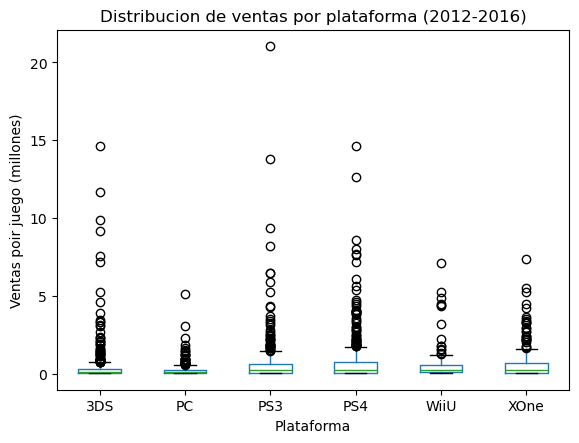

In [75]:
# Crea grafico boxplot con la distribucion de ventas por plataforma en el perdiodo 2012-2016
plt.figure(figsize=(10,6))
recent_games.boxplot(
    column='total_sales',
    by= 'platform',
    grid=False,
)
plt.title('Distribucion de ventas por plataforma (2012-2016)')
plt.suptitle('')
plt.xlabel('Plataforma')
plt.ylabel('Ventas poir juego (millones)')
plt.show()

<Figure size 1000x600 with 0 Axes>

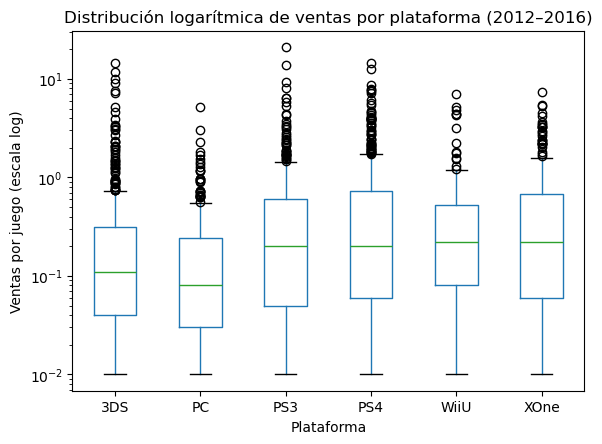

In [76]:
# Crea grafico boxplot con la distribucion de ventas por plataforma en el perdiodo 2012-2016 (logaritmico)
plt.figure(figsize=(10,6))
recent_games.boxplot(column='total_sales', by='platform', grid=False)
plt.yscale('log')
plt.title('Distribución logarítmica de ventas por plataforma (2012–2016)')
plt.suptitle('')
plt.xlabel('Plataforma')
plt.ylabel('Ventas por juego (escala log)')
plt.show()


### Conclusión – Distribución de ventas globales por plataforma


Se elaboró un diagrama de caja (boxplot) para comparar la distribución de las **ventas globales** de todos los juegos, desglosadas por plataforma, en el periodo 2012–2016.

**¿Son significativas las diferencias en las ventas?**  
Sí. Las diferencias entre plataformas son **claras y estadísticamente relevantes** a nivel descriptivo:  
- Las cajas del diagrama no se superponen completamente, lo que indica que las medianas y la dispersión varían de forma notable entre plataformas.  
- Las plataformas **PS4** y **XOne** presentan medianas más altas y una dispersión considerable, lo que refleja un mayor potencial de ventas por título y una alta variabilidad (éxitos grandes y fracasos ocasionales).  
- En contraste, **PC**, **3DS** y **WiiU** muestran medianas más bajas y menor rango intercuartil, lo que sugiere un mercado más estable pero con ventas promedio menores.

**¿Qué sucede con las ventas promedio en varias plataformas?**  
- Las **ventas promedio** son más elevadas en **PS4** y **XOne**, impulsadas por títulos AAA y franquicias de alto presupuesto.

- En **PC**, las ventas promedio son más moderadas, pero su dispersión baja refleja un mercado consistente sin picos extremos.  
- **3DS** y **WiiU** mantienen promedios bajos y concentrados, evidenciando un menor dinamismo comercial en sus últimos años.

**Hallazgos generales:**  
- Existen **outliers** importantes en todas las plataformas (ej. GTA, FIFA, Pokémon), que inflan las medias pero no alteran la tendencia general.  
- Las **diferencias entre medianas** confirman que las plataformas no tienen el mismo desempeño comercial: **PS4** y **XOne** son significativamente más rentables por título.  
- **PC** conserva una base sólida de ventas estables, mientras que **3DS** y **WiiU** muestran el cierre de su ciclo de vida.

**Conclusión general:**  
El análisis confirma que las plataformas **PS4** y **XOne** lideran en ventas globales promedio y mediana por juego, con diferencias significativas frente al resto.  
Estas consolas representan los mercados más rentables y activos en el periodo previo a 2017, justificando su elección como foco principal para los análisis posteriores.

---


#### Impacto de reseñas en las ventas

Objetivo
Analizar si existen relacion entre las calificaciones de criticos 'critic_score' y de usuarios 'user_score' con las ventas globales de los videojuegos.

Logica:
- Filtrar los datos del periodo y la plataforma a utilizar.
- Crear 1 DataFrame con:
  critic_score, total_sales
  user_score, total_sales
- Graficar buscando diferencias significativas
- Probar estadisticamente la fuerza de la relacion.

In [77]:
# Selecciona la plataforma y el periodo a utilizar
platform = 'PS4'
year_min, year_max = 2012, 2016


mask= (
    (df_games['platform'] == platform)
    & (df_games['year_of_release'] >= year_min)
    & (df_games['year_of_release'] <= year_max)
)

df_platforms = df_games.loc[mask, ['critic_score_scaled','user_score','total_sales']].copy() # Uso .copy() para evitar SettingWithCopyWarning y trabajar tranquilo.

In [78]:
#limpia pares de variables garantizando dos subconjuntos con mismos indices por par, necesarios para correlaciones y dispersion confiable.

# Par 1: críticos vs ventas
df_crit = df_platforms[['critic_score_scaled', 'total_sales']].dropna()

# Par 2: usuarios vs ventas
df_user = df_platforms[['user_score', 'total_sales']].dropna()


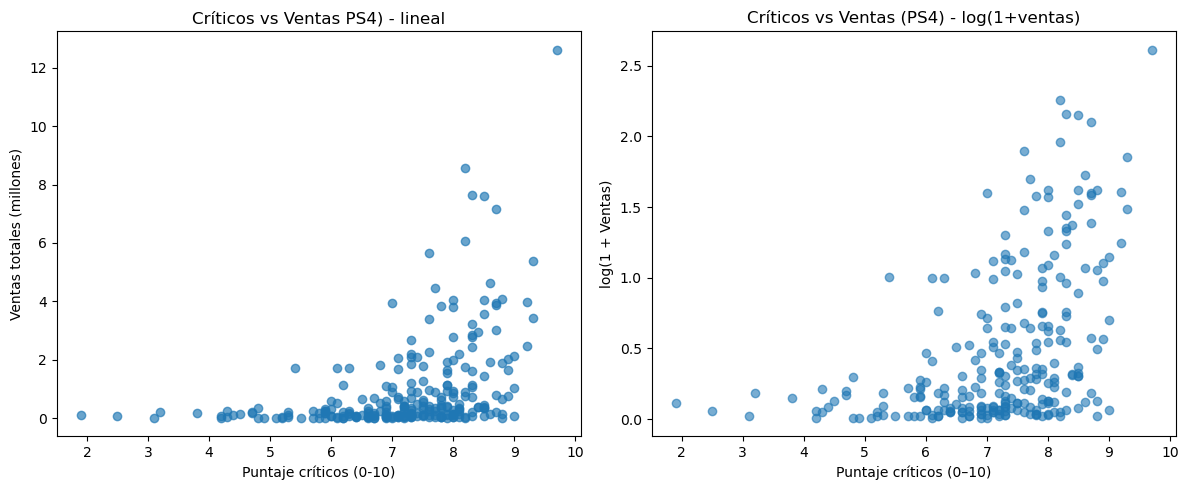

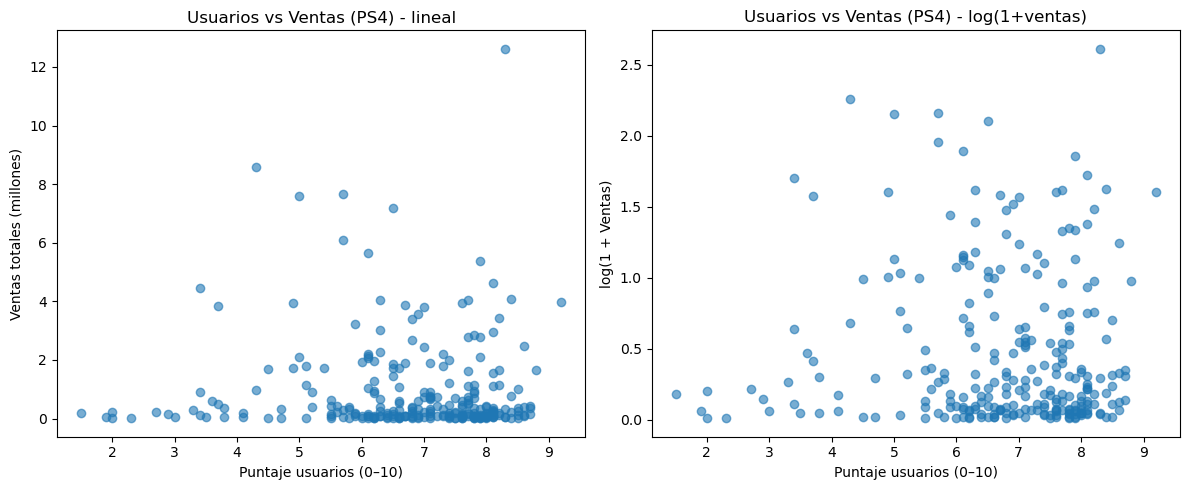

In [79]:
# Criticos vs Ventas
plt.figure(figsize=(12,5))

# Vista lineal
plt.subplot(1,2,1)
plt.scatter(df_crit['critic_score_scaled'],df_crit['total_sales'],alpha=0.67)
plt.title(f'Críticos vs Ventas {platform}) - lineal')
plt.xlabel('Puntaje críticos (0-10)')
plt.ylabel('Ventas totales (millones)')

# Vista log(reduce efecto outliers)

plt.subplot(1,2,2)
plt.scatter(df_crit['critic_score_scaled'], np.log1p(df_crit['total_sales']), alpha=0.6)
plt.title(f'Críticos vs Ventas ({platform}) - log(1+ventas)')
plt.xlabel('Puntaje críticos (0–10)')
plt.ylabel('log(1 + Ventas)')

plt.tight_layout()
plt.show()

# Usuarios vs Ventas 
plt.figure(figsize=(12,5))

# Vista lineal
plt.subplot(1,2,1)
plt.scatter(df_user['user_score'], df_user['total_sales'], alpha=0.6)
plt.title(f'Usuarios vs Ventas ({platform}) - lineal')
plt.xlabel('Puntaje usuarios (0–10)')
plt.ylabel('Ventas totales (millones)')

# Vista log
plt.subplot(1,2,2)
plt.scatter(df_user['user_score'], np.log1p(df_user['total_sales']), alpha=0.6)
plt.title(f'Usuarios vs Ventas ({platform}) - log(1+ventas)')
plt.xlabel('Puntaje usuarios (0–10)')
plt.ylabel('log(1 + Ventas)')

plt.tight_layout()
plt.show()


#### Tests de correlación (Pearson y Spearman) → para medir la fuerza y dirección de esa relación.

In [80]:
# Críticos vs Ventas
rho_s_c, p_s_c = st.spearmanr(df_crit['critic_score_scaled'], df_crit['total_sales'])
r_p_c, p_p_c   = st.pearsonr( df_crit['critic_score_scaled'], df_crit['total_sales'])

# Usuarios vs Ventas 
rho_s_u, p_s_u = st.spearmanr(df_user['user_score'], df_user['total_sales'])
r_p_u, p_p_u   = st.pearsonr( df_user['user_score'],  df_user['total_sales'])

print(f"[{platform}] N críticos={len(df_crit)}, N usuarios={len(df_user)}")

print("Críticos–Ventas  | Spearman: ρ={:.3f}, p={:.3g} | Pearson: r={:.3f}, p={:.3g}".format(rho_s_c, p_s_c, r_p_c, p_p_c))

print("Usuarios–Ventas  | Spearman: ρ={:.3f}, p={:.3g} | Pearson: r={:.3f}, p={:.3g}".format(rho_s_u, p_s_u, r_p_u, p_p_u))


[PS4] N críticos=252, N usuarios=257
Críticos–Ventas  | Spearman: ρ=0.508, p=5.89e-18 | Pearson: r=0.407, p=1.89e-11
Usuarios–Ventas  | Spearman: ρ=-0.028, p=0.651 | Pearson: r=-0.032, p=0.61


### Conclusión – Impacto de reseñas en las ventas (PS4)

El análisis de correlación entre las calificaciones y las ventas globales en la plataforma **PS4** (2012–2016) revela resultados contundentes:

- **Críticos vs Ventas:**  
  Existe una **correlación positiva moderada** (Spearman ρ = 0.51, p < 0.001), estadísticamente significativa.  
  Los juegos con mayores puntuaciones por parte de críticos tienden a registrar **mayores ventas globales**.  
  Esto sugiere que las reseñas profesionales tienen un **impacto real y medible** sobre el rendimiento comercial de los títulos.

- **Usuarios vs Ventas:**  
  La relación es **prácticamente nula** (Spearman ρ = -0.03, p = 0.65).  
  No se observa evidencia de que las puntuaciones de usuarios influyan en las ventas, lo cual indica que las opiniones del público no predicen el éxito económico.

**Interpretación general:**  
Las reseñas de críticos muestran una influencia significativa en las ventas, probablemente debido a su efecto en la visibilidad mediática y las decisiones de compra iniciales.  
Las calificaciones de usuarios, en cambio, reflejan la percepción posterior al lanzamiento y tienen **poca o ninguna relación** con el volumen de ventas.  
Por tanto, los esfuerzos de marketing y relaciones públicas orientados a medios especializados pueden ser más efectivos para impulsar las ventas de nuevos lanzamientos.

---


### Comparacion de las ventas de los mismos juegos en otras plataformas.

In [81]:
# Filtra el periodo 2012–2016 y las columnas útiles.
year_min, year_max = 2012, 2016
cols_needed = ['name','platform','year_of_release','total_sales']

mask_period = (
    (df_games['year_of_release'] >= year_min) &
    (df_games['year_of_release'] <= year_max)
)

df_p = (
    df_games.loc[mask_period, ['name','platform','total_sales']]
    .dropna(subset=['name','platform','total_sales'])
    .copy()
)

print(f"Periodo seleccionado: {year_min}–{year_max}")
print(f"Registros en periodo: {len(df_p):,}")


Periodo seleccionado: 2012–2016
Registros en periodo: 2,886


In [82]:
# Cuenta cuantas plataformas tiene cada juego
platform_count= df_p.groupby('name')['platform'].nunique()

# Selecciona solo los juegos con mas de una plataforma
multi_platform_games = platform_count[platform_count >1].index

print(f'Juegos multiplataforma detectados: {len(multi_platform_games)}')

Juegos multiplataforma detectados: 596


In [83]:
# Crea un subconjutno con los juegos previamente seleccionados
df_multi = df_games[df_games['name'].isin(multi_platform_games)][
    ['name','platform','total_sales']
].copy()

# Vista rapida
df_multi.head()

,name,platform,total_sales
16,Grand Theft Auto V,PS3,21.05
23,Grand Theft Auto V,X360,16.27
31,Call of Duty: Black Ops 3,PS4,14.63
34,Call of Duty: Black Ops II,PS3,13.79
35,Call of Duty: Black Ops II,X360,13.68


In [84]:
# Crea una tabla comparativa 
sales_by_platform = ( 
    df_multi.pivot_table(
    index='name',
    columns='platform',
    values='total_sales',
    aggfunc='sum'
).fillna(0).sort_index()
)

# vista rapida
sales_by_platform.head()

platform,3DS,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
name,,,,,,,,,,,,,,,
Frozen: Olaf's Quest,0.59,0.51,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00
2014 FIFA World Cup Brazil,0.00,0.00,0.0,0.0,0.0,0.0,0.61,0.00,0.0,0.00,0.0,0.0,0.43,0.0,0.00
3rd Super Robot Wars Z Jigoku Hen,0.00,0.00,0.0,0.0,0.0,0.0,0.23,0.00,0.0,0.19,0.0,0.0,0.00,0.0,0.00
3rd Super Robot Wars Z: Tengoku-Hen,0.00,0.00,0.0,0.0,0.0,0.0,0.15,0.00,0.0,0.19,0.0,0.0,0.00,0.0,0.00
7 Days to Die,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.14,0.0,0.00,0.0,0.0,0.00,0.0,0.05


In [85]:
# Resumen por plataforma
platform_summary = (
        df_multi
        .groupby('platform')['total_sales']
        .agg(mean_sales='mean', median_sales='median', games='size') # Promedio y mediana de ventas por juego y plataforma.
        .sort_values('mean_sales', ascending=False)  #  Cuenta juegos por plataforma en el conjunto multiplataforma
    )

print("\nResumen por plataforma (solo juegos multiplataforma; ordenado por media):")
display(platform_summary)


Resumen por plataforma (solo juegos multiplataforma; ordenado por media):


,mean_sales,median_sales,games
platform,,,
PS2,1.597500,0.980,4
PS4,0.884335,0.265,316
X360,0.835396,0.325,278
PS3,0.699974,0.260,389
Wii,0.692955,0.180,44
GC,0.636667,0.560,3
XOne,0.603080,0.220,224
XB,0.570000,0.570,2
3DS,0.308588,0.130,85



Graficando comparación de ventas por plataforma para top 8 juegos multiplataforma...


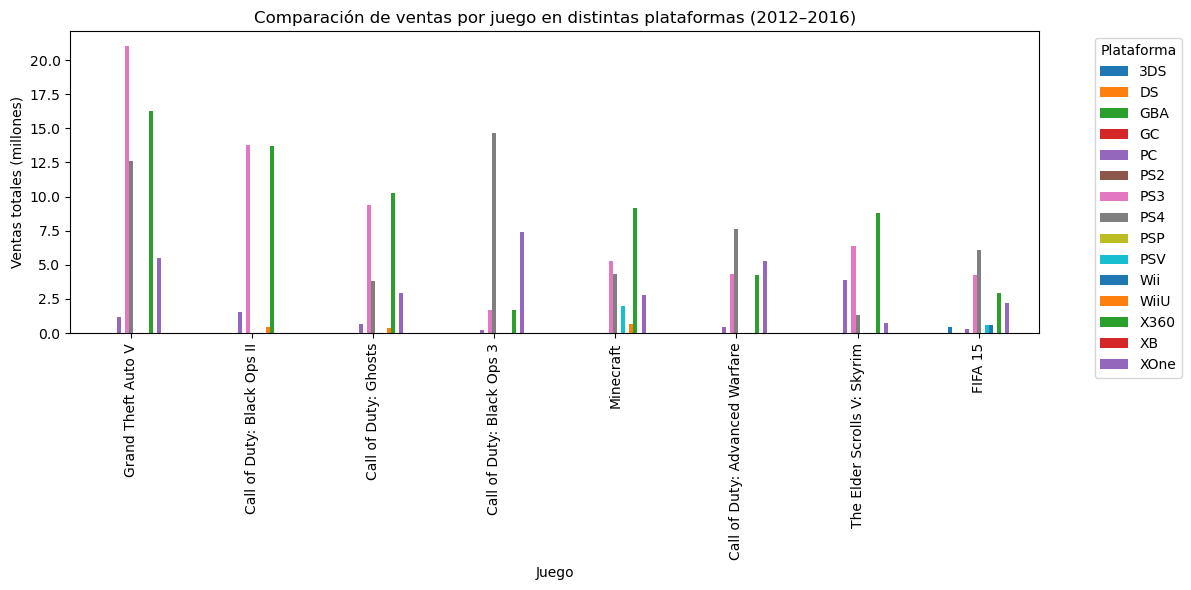

In [86]:
# Grafica una comparacion de ventas por juego en distintas plataformas
N = 8  
topN_games = (
        df_multi.groupby('name')['total_sales'].sum()
        .sort_values(ascending=False)
        .head(N)
        .index
    )

if len(topN_games) > 0:
        print(f"\nGraficando comparación de ventas por plataforma para top {N} juegos multiplataforma...")
        plot_df = sales_by_platform.loc[topN_games]

        ax = plot_df.plot(kind='bar', figsize=(12,6))
        ax.set_title(f'Comparación de ventas por juego en distintas plataformas ({year_min}–{year_max})')
        ax.set_xlabel('Juego')
        ax.set_ylabel('Ventas totales (millones)')
        ax.legend(title='Plataforma',bbox_to_anchor=(1.05,1),loc='upper left')
        plt.tight_layout()
        plt.show()



### Comparación de ventas de los mismos juegos en distintas plataformas (2012–2016)

El análisis de los títulos multiplataforma entre 2012 y 2016 muestra **diferencias claras de rendimiento comercial entre plataformas**, tanto a nivel agregado como por juego individual.

**Resultados generales:**
- La plataforma con **mayor media de ventas por juego** es **PS4 (0.88 millones)**, seguida por **Xbox 360 (0.81 millones)** y **Xbox One (0.60 millones)**.  
- La **diferencia promedio** entre PS4 y Xbox 360 es de aproximadamente **0.08 millones de copias por título**, confirmando que PS4 domina el mercado multiplataforma de su generación.  
- Plataformas como **PC (0.28 M)**, **3DS (0.31 M)** y **WiiU (0.30 M)** muestran menores ventas por juego, reflejando públicos más segmentados y menor presencia en títulos multiplataforma AAA.

**Evidencia visual:**
El gráfico de los 8 juegos multiplataforma más vendidos (GTA V, Call of Duty, FIFA, Minecraft, etc.) muestra un patrón consistente:
- En casi todos los casos, las versiones de **PS4** y **PS3/X360** concentran las **mayores ventas**, superando a las de **PC**, **3DS** o **WiiU**.  
- **PS4** aparece como la consola más rentable para lanzamientos AAA, mientras que **PC** y plataformas portátiles tienen un peso menor.  

**Interpretación analítica:**
- El éxito de un título no depende solo de su calidad o popularidad, sino también de la **base de usuarios activa** de cada consola.  
- Las consolas **PS4 y Xbox One** dominaron el mercado en esta etapa gracias a su alcance global y campañas exclusivas.  
- **PC** mantiene presencia, especialmente en géneros específicos (estrategia, simulación), pero con menor impacto en el segmento multiplataforma.

**Conclusión general:**
El análisis confirma que los juegos multiplataforma **venden considerablemente más en consolas de nueva generación (PS4, XOne)** que en plataformas anteriores o de nicho.  
Esto refuerza la importancia estratégica de **optimizar lanzamientos para las consolas líderes**, donde la rentabilidad por título es más alta y el público objetivo más amplio.

---


### Análisis por género

Objetivo

Determinar:

- Cuales géneros son mas populares y rentables en terminos de ventas totales.
- Que tan rentable es un juego promedio dentro de cada género.
- Que géneros tienen mas riesgo o variabilidad(ejemplo, muchos juegos malos pero algunos exitos enormes)

Logica

- Agrupar ventas por genero:

*Tamaño del mercado (cuantos juegos hay por genero).*

*Ingresos totales(suma de venta en millones).*

*Ventas promedio (mide rentabilidad tipica).*

- Analizar metricas clave.

- Ordenar los resultados y visualizar.


In [87]:
# Selecciona el periodo y las columnas  a utilizar
year_min, year_max = 2012, 2016

mask = (
    (df_games['year_of_release'] >= year_min) &
    (df_games['year_of_release'] <= year_max)
)

# Filtramos y copiamos para trabajar sin warnings
df_recent = df_games.loc[mask, ['name', 'genre', 'total_sales']].copy()

In [88]:
# Agrupa las ventas por genero
genre_data = (df_recent
    .groupby('genre',as_index=True)
    .agg(
        games=('genre','size'), # Cuenta los juegos agrupados por genero.
        total_sales=('total_sales','sum'), # Suma las ventas totales por genero.
        mean_sales=('total_sales','mean'), # Calcula al media de las ventas totales por genero.
        median_sales=('total_sales','median') # Calcula la mediana de las ventas totales por genero.
    )
)

# Vista rapida
genre_data.head()

,games,total_sales,mean_sales,median_sales
genre,,,,
Action,1031,441.12,0.427856,0.12
Adventure,302,29.43,0.097450,0.03
Fighting,109,44.49,0.408165,0.13
Misc,192,85.04,0.442917,0.12
Platform,85,61.00,0.717647,0.21


In [89]:
# Crea una variable con las ventas totales por genero
total_global = genre_data['total_sales'].sum()

# Calcula el tamaño de la participacion de mercado por genero.
genre_data['market_share_%']= 100*genre_data['total_sales'] / total_global

#visualizacion rapida
genre_data.head()

,games,total_sales,mean_sales,median_sales,market_share_%
genre,,,,,
Action,1031,441.12,0.427856,0.12,30.495047
Adventure,302,29.43,0.097450,0.03,2.034524
Fighting,109,44.49,0.408165,0.13,3.075636
Misc,192,85.04,0.442917,0.12,5.878896
Platform,85,61.00,0.717647,0.21,4.216988


In [90]:
#Crea  2 rankings uno por el total y otro por la media
ranking_per_total = (
    genre_data
    .sort_values('total_sales', ascending=False)
    .round({'total_sales': 2, 'mean_sales': 3, 'median_sales': 3, 'market_share_%': 1})
)

ranking_per_median = (
    genre_data
    .sort_values('median_sales', ascending=False)
    .round({'total_sales': 2, 'mean_sales': 3, 'median_sales': 3, 'market_share_%': 1})
)

# Vista rápida
display(ranking_per_total.head(10)) #Por total identifica géneros dominantes en ingresos.
display(ranking_per_median.head(10)) #Por mediana identifica géneros rentables por título (útil para priorizar si hay pocos lanzamientos)


,games,total_sales,mean_sales,median_sales,market_share_%
genre,,,,,
Action,1031,441.12,0.428,0.12,30.5
Shooter,235,304.73,1.297,0.44,21.1
Role-Playing,370,192.80,0.521,0.14,13.3
Sports,268,181.07,0.676,0.24,12.5
Misc,192,85.04,0.443,0.12,5.9
Platform,85,61.00,0.718,0.21,4.2
Racing,115,53.50,0.465,0.14,3.7
Fighting,109,44.49,0.408,0.13,3.1
Simulation,80,35.12,0.439,0.12,2.4


,games,total_sales,mean_sales,median_sales,market_share_%
genre,,,,,
Shooter,235,304.73,1.297,0.44,21.1
Sports,268,181.07,0.676,0.24,12.5
Platform,85,61.00,0.718,0.21,4.2
Role-Playing,370,192.80,0.521,0.14,13.3
Racing,115,53.50,0.465,0.14,3.7
Fighting,109,44.49,0.408,0.13,3.1
Action,1031,441.12,0.428,0.12,30.5
Misc,192,85.04,0.443,0.12,5.9
Simulation,80,35.12,0.439,0.12,2.4


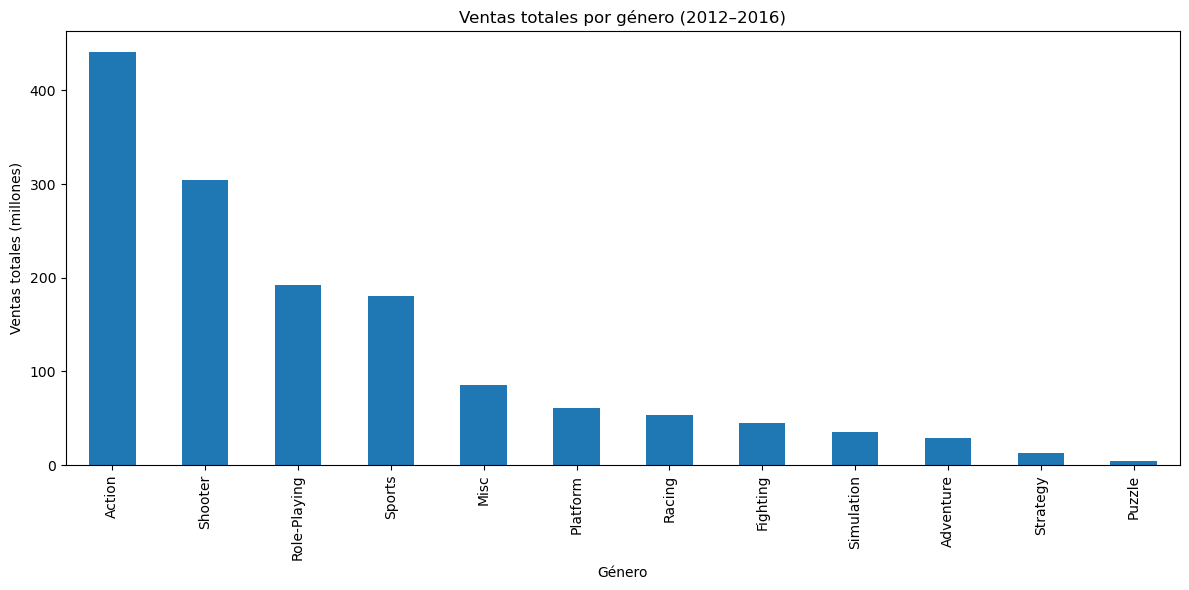

In [91]:
# Grafica las ventas totales por género (tamaño del mercado).
ax = ranking_per_total['total_sales'].plot(
    kind='bar',
    figsize=(12,6),
    title='Ventas totales por género (2012–2016)'
)
ax.set_xlabel('Género')
ax.set_ylabel('Ventas totales (millones)')
plt.tight_layout()
plt.show()


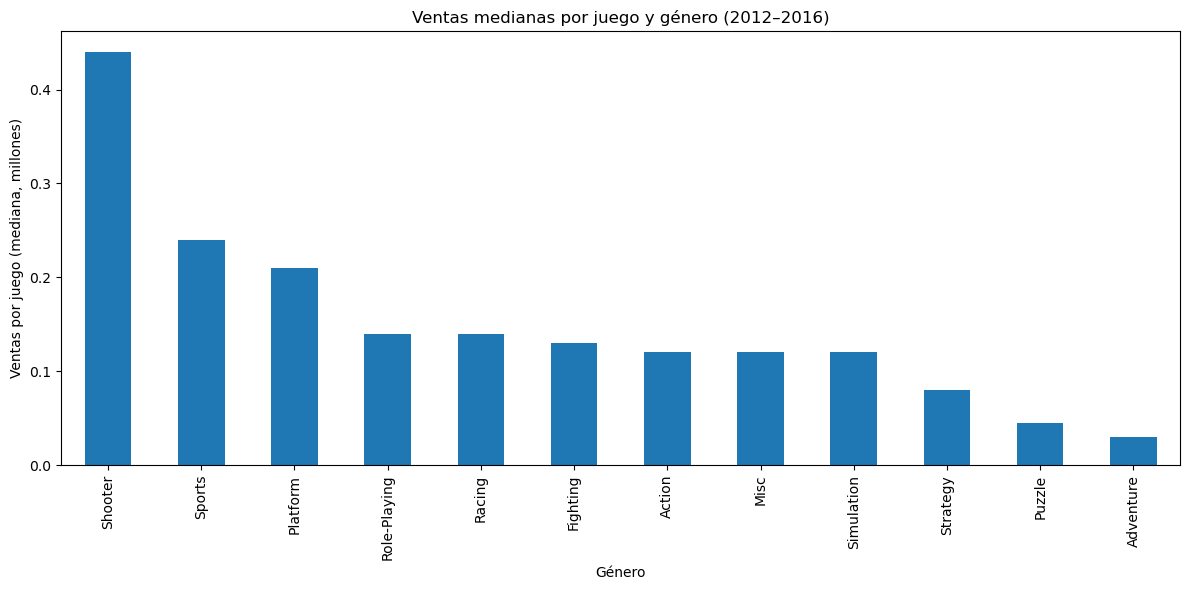

In [92]:
# Grafica la mediana de ventas por genero (rentabilidad tipica)
ax = ranking_per_median['median_sales'].plot(
    kind='bar',
    figsize=(12,6),
    title='Ventas medianas por juego y género (2012–2016)'
)
ax.set_xlabel('Género')
ax.set_ylabel('Ventas por juego (mediana, millones)')
plt.tight_layout()
plt.show()


### Análisis de ventas por género (2012–2016)

- **Tamaño de mercado (ventas totales):** Los géneros con mayor contribución global son 'Action', 'Shooters' y 'Role-Playing', concentrando ~60% del total.  
- **Rentabilidad típica por juego (mediana):** Destacan 'Shooter' y 'Sport' con las **ventas medianas** más altas por título, lo que sugiere mejor retorno por lanzamiento.  
- **Promedios vs medianas:** En géneros como 'action' la **media** es alta pero la **mediana** baja, señal de **alta desigualdad** (pocos megaéxitos elevan el promedio).  


**Conclusión general:**  
Para 2017 conviene priorizar géneros con **gran mercado** y **buena mediana por título** (p.ej., 'Shooters' y 'Role-Playing'); Géneros de nicho ('Action') pueden complementar el portafolio por su estabilidad, aunque con menor impacto en ingresos.

---


### Crea un perfil de usuario para cada región
Para cada región (NA, UE, JP) determina:

obejtivo
- Top-5 plataformas y sus cuotas de mercado en esa region.
- Top-5 generos y sus cuotas de mercado en esa region.
- ¿Las clasificaciones ESRB afectan a las ventas en esa región?

In [93]:
#Selecciona el periodo de tiempo y las columnas necesarias y crea un DF.
year_min, year_max = 2012,2016
region_col_map = {'NA': 'na_sales','EU':'eu_sales','JP':'jp_sales'}

required_cols = {'name','platform','genre','rating','year_of_release','na_sales','eu_sales','jp_sales'}

missing = required_cols - set(df_games.columns.str.lower())
if missing:
    raise KeyError(f'Faltan columnas en df_games: {missing}')

mask_period =(df_games['year_of_release'] >= year_min) & (df_games['year_of_release'] <= year_max)

df_base= df_games.loc[mask_period,list(required_cols)].copy()

print(f'Periodo:{year_min}-{year_max} | Registros: {len(df_base):,}')

Periodo:2012-2016 | Registros: 2,886


In [94]:
# Funcion para construir un data frame regional

def build_region_frame(dF_base,region:str) -> tuple[pd.DataFrame,str]:
    if region not in region_col_map:
        raise ValueError('La region debe ser "NA","EU" o "JP"')
    sales_col= region_col_map[region]
    cols_needed= ['name','platform','genre','rating',sales_col]
    df_region= (
            df_base.loc[:, cols_needed]
            .dropna(subset=[sales_col])
            .copy()
        )
    return df_region, sales_col

# ejemplo de uso:

df_na,col_na = build_region_frame(df_base,'NA')
print(df_na.head(2)); print('Columna NA :',col_na)
        

                  name platform   genre rating  na_sales
16  Grand Theft Auto V      PS3  Action      M      7.02
23  Grand Theft Auto V     X360  Action      M      9.66
Columna NA : na_sales


In [95]:
# agrupa y calcula ventas y cuota de mercado

def aggregate_top5(df_region: pd.DataFrame, group_cols: str,sales_col: str):
    #ventas absolutas por categoria
    sales= (df_region.groupby(group_cols, as_index=True)[sales_col]
            .sum()
            .sort_values(ascending=False))
    total= sales.sum()
    share=(sales / total * 100)

    table= pd.DataFrame({
        'ventas':sales.round(2),
        'cuota_%': share.round(2)
    })

    #selecciona el top 5
    top5=table.head(5).copy()
    return table,top5,float(total)

#prueba rapida
tbl_na_plat,top5_na_plat,total_na = aggregate_top5(df_na,'platform',col_na)
display(top5_na_plat); print('Total NA:',total_na)

,ventas,cuota_%
platform,,
X360,140.05,23.70
PS4,108.74,18.40
PS3,103.38,17.49
XOne,93.12,15.76
3DS,55.31,9.36


Total NA: 590.97


#### Top-5 plataformas y sus cuotas de mercado en esa region.

In [96]:
#top 5 plataformas por region

#NA
df_na, col_na = build_region_frame(df_base,'NA')
plat_na,plat_na_top5,total_na = aggregate_top5(df_na,'platform',col_na)

print('NA Top-5 plataformas por cuota (%):');display(plat_na_top5)

#EU
df_eu, col_eu= build_region_frame(df_base,'EU')
plat_eu, plat_eu_top5, total_eu= aggregate_top5(df_eu,'platform',col_eu)

print('EU Top-5 plataformas por cuota (%):');display(plat_eu_top5)

#JP

df_jp, col_jp = build_region_frame(df_base, 'JP')
plat_jp, plat_jp_top5, total_jp = aggregate_top5(df_jp,'platform',col_jp)
print(' JP Top-5 plataformas por cuota (%):');display(plat_jp_top5)

NA Top-5 plataformas por cuota (%):


,ventas,cuota_%
platform,,
X360,140.05,23.70
PS4,108.74,18.40
PS3,103.38,17.49
XOne,93.12,15.76
3DS,55.31,9.36


EU Top-5 plataformas por cuota (%):


,ventas,cuota_%
platform,,
PS4,141.09,27.84
PS3,106.86,21.08
X360,74.52,14.70
XOne,51.59,10.18
3DS,42.64,8.41


 JP Top-5 plataformas por cuota (%):


,ventas,cuota_%
platform,,
3DS,87.79,45.59
PS3,35.29,18.32
PSV,21.04,10.93
PS4,15.96,8.29
WiiU,13.01,6.76


### Grafico - Top-5 Plataformas por Region ###

<Figure size 1000x600 with 0 Axes>

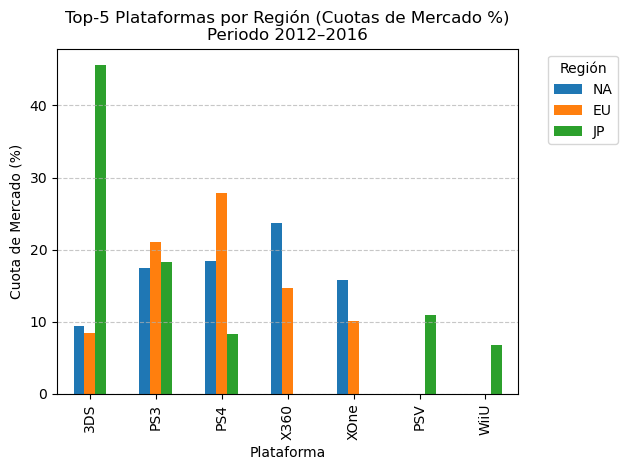

In [97]:
# Grafico - Top-5 Plataformas por Region


# Combina las cuotas de mercado (%) de las plataformas en un solo DataFrame
combined_platform_share = pd.DataFrame({
    'NA': plat_na_top5['cuota_%'],
    'EU': plat_eu_top5['cuota_%'],
    'JP': plat_jp_top5['cuota_%']
}).fillna(0)

# Ordena por promedio general de cuota (solo para estética)
combined_platform_share['mean'] = combined_platform_share.mean(axis=1)
combined_platform_share = combined_platform_share.sort_values('mean', ascending=False).drop(columns='mean')

# Grafico
plt.figure(figsize=(10,6))
combined_platform_share.plot(kind='bar')
plt.title('Top-5 Plataformas por Región (Cuotas de Mercado %)\nPeriodo 2012–2016')
plt.xlabel('Plataforma')
plt.ylabel('Cuota de Mercado (%)')
plt.legend(title='Región', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### top-5 plataformas por region (2021-2016)

**Resultados generales**
- En **Norteamerica (NA)** las ventas se concentran principalmente en **PS4** y **Xbox One**, que juntas superan el `60 % del mercado. laa **3DS** mantiene una cuota relevante debido al segmento portatil.
- En **Europa (EU)**, **PS4** y **PS3** dominan el emrcado: **Xbox One** ocupa el terecer lugar con una presencia mas moderada.
- En **Japón (JP)** predomina el ecositema Nintendo (**3DS** y **Wii U**) junto con **PSV** y **PS4**, reflejando la preferencia local por consolas portatiles.

**Interpretacion**
- Las regiones occidentales (NA/EU) Muestran una clara orientacion hacia consolas de sobremesa Sony y Microsoft, asociadas al catalogo AAA de alta demanda.
- Japon en cambio, mantiene un mercado mas diversificado y portatil, influido por la distribucion local y habitos de movilidad.

  **Conclusion**

  > Las cuotas de mercado varian significativamente por region:

  > **PS4/XOne** dominan el mercado en Ocidente, mientras que **Nintendo y Sony portatiles** son lideres en Japon. Estas diferencias deben considerarse al planificar campañas de 2017 por mercado objetivo.

#### Top-5 generos y sus cuotas de mercado en esa region.

In [98]:
# NA
genre_na, genre_na_top5, _ = aggregate_top5(df_na, 'genre', col_na)
print("[NA] Top-5 géneros por cuota (%):"); display(genre_na_top5)

# EU
genre_eu, genre_eu_top5, _ = aggregate_top5(df_eu, 'genre', col_eu)
print("[EU] Top-5 géneros por cuota (%):"); display(genre_eu_top5)

# JP
genre_jp, genre_jp_top5, _ = aggregate_top5(df_jp, 'genre', col_jp)
print("[JP] Top-5 géneros por cuota (%):"); display(genre_jp_top5)


[NA] Top-5 géneros por cuota (%):


,ventas,cuota_%
genre,,
Action,177.84,30.09
Shooter,144.77,24.50
Sports,81.53,13.80
Role-Playing,64.00,10.83
Misc,38.19,6.46


[EU] Top-5 géneros por cuota (%):


,ventas,cuota_%
genre,,
Action,159.34,31.44
Shooter,113.47,22.39
Sports,69.09,13.63
Role-Playing,48.53,9.58
Racing,27.29,5.38


[JP] Top-5 géneros por cuota (%):


,ventas,cuota_%
genre,,
Role-Playing,65.44,33.98
Action,52.80,27.42
Misc,12.86,6.68
Simulation,10.41,5.41
Fighting,9.44,4.90


### Grafico - Top-5 Géneros por Región ###

<Figure size 1000x600 with 0 Axes>

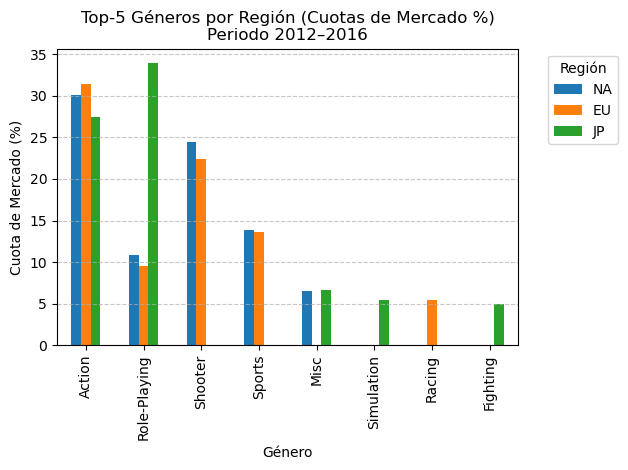

In [99]:

# Grafico - Top-5 Géneros por Región


combined_genre_share = pd.DataFrame({
    'NA': genre_na_top5['cuota_%'],
    'EU': genre_eu_top5['cuota_%'],
    'JP': genre_jp_top5['cuota_%']
}).fillna(0)

# Ordena por promedio
combined_genre_share['mean'] = combined_genre_share.mean(axis=1)
combined_genre_share = combined_genre_share.sort_values('mean', ascending=False).drop(columns='mean')          

# Grafico
plt.figure(figsize=(10,6))
combined_genre_share.plot(kind='bar')
plt.title('Top-5 Géneros por Región (Cuotas de Mercado %)\nPeriodo 2012–2016')
plt.xlabel('Género')
plt.ylabel('Cuota de Mercado (%)')
plt.legend(title='Región', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top-5 géneros por region (2021-2016)

**Norteamerica (NA)**
- Generos dominantes: **Action**, **Shooter** y **Sports**, que concentran mas del 60% de las ventas.
- El gusto del mercado estadounidense esta centrrado en titulos competitivos y de accion rapida.

**Europa (EU)**
-  Generos dominantes:**Action** y **Sports** lideran, seguidos de **Shooters** y **Roleplaying**.
-  El peso europeo de **Sports** (particularmente FIFA) es superior al norteamericano.

**Japon (JP)**
- Los generos mas populares son **Roleplaying** y **platform**, con cuotas muy superiores a occidente.
- Los titulos de accion occidenteales tiene menor impacto relativo.

**Conclusion**
> Las preferencias de genero reflejan diferencias culturales:
> Occidente prefiere titulos de accion y disparo, mientras que Japon valora mas los juegos de narrativa y plataforma una estrategia global debe adopatar el catalogo por region para maximizar ventas.
> 

### las clasificaciones de ESRB afectan a las ventas en regiones individuales?

In [100]:
def esrb_table(df_region: pd.DataFrame, sales_col: str):
    esrb_sales = (df_region.groupby('rating', as_index=True)[sales_col]
                             .sum()
                             .sort_values(ascending=False))
    total = esrb_sales.sum()
    table = pd.DataFrame({
        'ventas': esrb_sales.round(2),
        'cuota_%': (esrb_sales/total*100).round(2)
    })
    return table

print("[NA] ESRB:"); display(esrb_table(df_na, col_na))
print("[EU] ESRB:"); display(esrb_table(df_eu, col_eu))
print("[JP] ESRB:"); display(esrb_table(df_jp, col_jp))


[NA] ESRB:


,ventas,cuota_%
rating,,
M,231.57,39.18
E,114.37,19.35
unknown,103.31,17.48
E10+,75.70,12.81
T,66.02,11.17


[EU] ESRB:


,ventas,cuota_%
rating,,
M,193.96,38.27
E,113.03,22.30
unknown,91.50,18.05
E10+,55.37,10.92
T,52.96,10.45


[JP] ESRB:


,ventas,cuota_%
rating,,
unknown,108.84,56.52
E,28.33,14.71
T,26.02,13.51
M,21.20,11.01
E10+,8.19,4.25


###  Grafico - Clasificación ESRB por Región ###

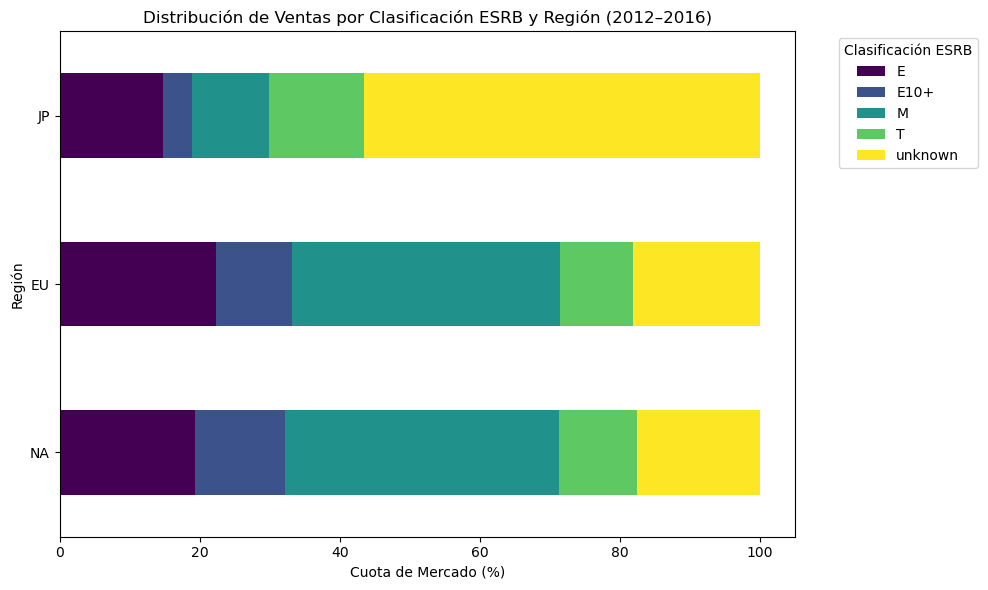

In [101]:
# Grafico - Clasificación ESRB por Región

# Convertir tablas ESRB a Series de cuota (%)
esrb_na = esrb_table(df_na, col_na)['cuota_%']
esrb_eu = esrb_table(df_eu, col_eu)['cuota_%']
esrb_jp = esrb_table(df_jp, col_jp)['cuota_%']

# Unir todo en un DataFrame
esrb_combined = pd.DataFrame({
    'NA': esrb_na,
    'EU': esrb_eu,
    'JP': esrb_jp
}).fillna(0)

# Transponer para mostrar regiones como filas
esrb_combined = esrb_combined.T

# --- Gráfico apilado horizontal ---
esrb_combined.plot(
    kind='barh',
    stacked=True,
    figsize=(10,6),
    cmap='viridis'
)
plt.title('Distribución de Ventas por Clasificación ESRB y Región (2012–2016)')
plt.xlabel('Cuota de Mercado (%)')
plt.ylabel('Región')
plt.legend(title='Clasificación ESRB', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Clasificacion ESRB y ventas por regiion (2012-2016)

**Norteamerica (NA)**
- Predominan las clasificaciones **M (Mature)** y **T (Teen)**, qye representa la mayor parte del mercado.
- Los titulos familiares (E Everyone) mantienen una presencia constante pero menor.

**Europa (EU)**
- Distribucion similar a NA: mayor peso de M y T por el catalogo AAA occidental.
- Los titulos familiares (E Everyone) mantienen una presencia constante pero menor.

**Japon (JP)**
- Las ventas se concentran en juegos clasificados **E y T**, acordes a un mercado mas familiar y de portatiles.
- Los titulos Mature tienen una participacion menor.

**Conclusion**
> Las prefenrencias por rating reglejan la estructura cultural de cada mercado:
> **Occidente favorece titulos M/T para publico adolescente y adulto**, mientras que ** Japon se inclina por categorias E/T**. la variable ESRB si impacta las ventas regionalmente y debe considerarse en estrategias de localizacion y marketing.



### Prueba de hipotesis

In [102]:
#Preparamos el dataset base
# Parametros globales
alpha = 0.05
year_min, year_max = 2012,2016

#filtra temporal

mask_period = (
    (df_games['year_of_release'] >= year_min) &
    (df_games['year_of_release']<= year_max)
)

# Columnas necesarias

cols = ['name','platform','genre','user_score','year_of_release']

# Subset y limpieza de user_score
df5= df_games.loc[mask_period, cols].copy()
df5['user_score'] = pd.to_numeric(df5['user_score'],errors='coerce')
df5= df5.dropna(subset=['user_score'])

print(f"Periodo {year_min}-{year_max} | Filas con user_score válido: {len(df5):,}")
display(df5[['platform','genre','user_score']].sample(min(5, len(df5)), random_state=42))

Periodo 2012-2016 | Filas con user_score válido: 1,531


,platform,genre,user_score
5165,PC,Strategy,5.5
471,X360,Shooter,8.6
2264,3DS,Action,8.2
13958,PC,Simulation,4.0
4490,PS3,Fighting,7.5


### Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas?

**Formulación de hipótesis**

- **Hipótesis nula (H₀):** las medias de las calificaciones de los usuarios (`user_score`) son iguales entre las plataformas **Xbox One** y **PC**.  
  μ_XOne = μ_PC  
- **Hipótesis alternativa (H₁):** las medias de las calificaciones de los usuarios son diferentes entre **Xbox One** y **PC**.  
  μ_XOne ≠ μ_PC  
- **Tipo de prueba:** bicaudal (no se asume de antemano cuál plataforma tendría puntuaciones más altas).  
- **Nivel de significancia:** α = 0.05  
---

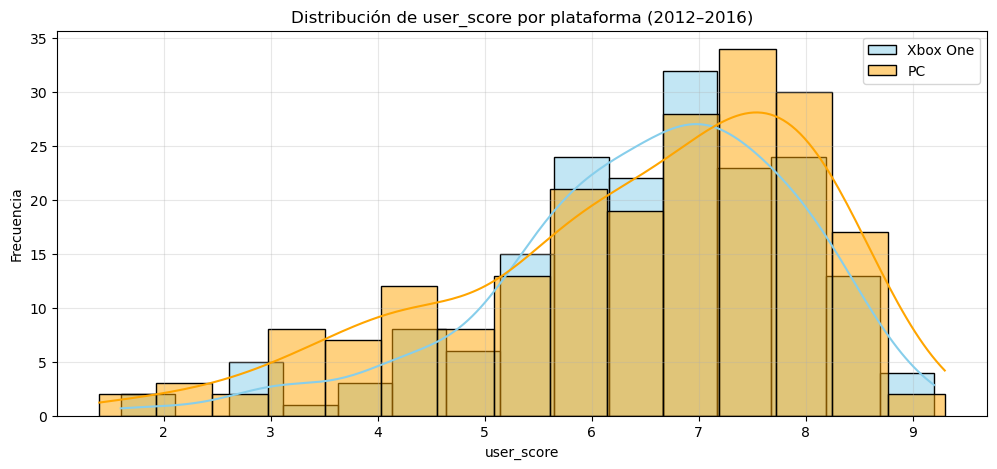

In [103]:
# Grafico de distribucion

# Configuración de figura
plt.figure(figsize=(12,5))

# Histograma comparativo
sns.histplot(xone_scores, color='skyblue', label='Xbox One', kde=True, bins=15)
sns.histplot(pc_scores, color='orange', label='PC', kde=True, bins=15)

plt.title('Distribución de user_score por plataforma (2012–2016)')
plt.xlabel('user_score')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [104]:
# Test de normalidad (Shapiro- Wilk)

from scipy.stats import shapiro

sh_xone = shapiro(xone_scores)
sh_pc   = shapiro(pc_scores)

print(f"Shapiro Xbox One: W={sh_xone.statistic:.3f}, p={sh_xone.pvalue:.4f}")
print(f"Shapiro PC:       W={sh_pc.statistic:.3f}, p={sh_pc.pvalue:.4f}")


Shapiro Xbox One: W=0.955, p=0.0000
Shapiro PC:       W=0.938, p=0.0000


In [105]:
 # Extrae las dos muestras.

# Seleccionamos los juegos para cada plataforma
xone_scores = df5.loc[df5['platform'] == 'XOne','user_score'].to_numpy()

pc_scores = df5.loc[df5['platform'] == 'PC', 'user_score'].to_numpy()


# Cuenta cuantas observaciones tiene cada grupo

n_xone = len(xone_scores)
n_pc = len(pc_scores)

# Resumen rapido

print(f"Xbox One: {n_xone} observaciones | PC: {n_pc} observaciones")
print(f"Media XOne = {np.mean(xone_scores):.3f} | Media PC = {np.mean(pc_scores):.3f}")

Xbox One: 182 observaciones | PC: 206 observaciones
Media XOne = 6.521 | Media PC = 6.429


In [106]:
# Ejecuta Welch t-test y Mann-Whitney U 

#Welch (parametrico)
t_stat, p_welch = st.ttest_ind(xone_scores, pc_scores, equal_var = False)

# Mann-Whitney (no parametrico)
u_stat, p_mwu = st.mannwhitneyu(xone_scores, pc_scores, alternative = 'two-sided')

print(f'[Welch] t = {t_stat:.3f} | p = {p_welch:.4f}')
print(f'[Mann-Whitney] U = {u_stat: .0f} | p = {p_mwu: .4f}')

[Welch] t = 0.600 | p = 0.5490
[Mann-Whitney] U =  18558 | p =  0.8649



### Xbox One vs PC (user_score, 2012–2016)

**Comprobación de supuestos**

Antes de seleccionar el test estadístico, se analizaron los supuestos de normalidad y homogeneidad de varianzas:

- **Distribución visual:** Los histogramas de `user_score` para Xbox One y PC mostraron formas asimétricas, alejadas de una campana normal.
- **Test de normalidad (Shapiro–Wilk):**  
  - Xbox One → W = 0.955, p = 0.0000  
  - PC → W = 0.938, p = 0.0000  
  En ambos casos, p < 0.05 indica que las muestras **no son normales**.

Por lo tanto, se decidió utilizar el **t-test de Welch**, que no asume varianzas iguales ni normalidad estricta,  
y contrastar los resultados con el **test no paramétrico de Mann–Whitney U**.


**Criterio de prueba**

> Las calificaciones de los usuarios (`user_score`) no siguen una distribución perfectamente normal y las varianzas entre los grupos pueden diferir.  
>  
> Por esta razón se utilizó el **t-test de Welch** (`st.ttest_ind(a, b, equal_var=False)`), que **no asume varianzas iguales** y es robusto frente a tamaños de muestra desbalanceados.  
>  
> Como contraste robusto, también se aplicó el **test no paramétrico de Mann–Whitney U**, que **compara distribuciones sin requerir normalidad**.  
>  
> De esta forma se asegura que los resultados sean válidos tanto bajo supuestos paramétricos como no paramétricos.


**Resultados**

- Welch: t = 0.600, p = 0.549  
- Mann–Whitney: U = 18558, p = 0.8649  



**Conclusión estadística**

> Dado que ambos p-valores son mayores que 0.05, **no se rechaza H₀**.  
> No existe evidencia estadísticamente significativa de que las calificaciones promedio de los usuarios difieran entre **Xbox One** y **PC**.



**Interpretación analítica**

> Las percepciones de los usuarios son **similares entre ambas plataformas**, lo que indica que las valoraciones dependen más del contenido de los juegos que del hardware en si.
> En términos de marketing o diseño de catálogo, esto sugiere que un mismo título puede obtener **recepción equivalente** en ambas plataformas, por lo que las campañas publicitarias pueden **mantener una estrategia uniforme** para estos mercados.

---

### Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

**Formulación de hipótesis**

- **Hipótesis nula (H₀):** Las medias de las calificaciones de los usuarios (`user_score`) son iguales entre los géneros **Acción** y **Deportes**.  
  μ_Action = μ_Sports  

- **Hipótesis alternativa (H₁):** Las medias de las calificaciones de los usuarios son diferentes entre los géneros **Acción** y **Deportes**.  
  μ_Action ≠ μ_Sports  

- **Tipo de prueba:** Bicaudal (no se asume de antemano cuál género tiene calificaciones más altas).  

- **Nivel de significancia:** α = 0.05


In [107]:
# Extrae muestras para cada genero.
action_scores = df5.loc[df5['genre'] == 'Action','user_score'].to_numpy()
sport_scores = df5.loc[df5['genre'] == 'Sports','user_score'].to_numpy()

# Tamaños de la muestra
n_action = len(action_scores)
n_sport = len(sport_scores)


#  Medias descriptivas
m_action = np.mean(action_scores)
m_sport = np.mean(sport_scores)



print(F'Accion : n={n_action}, media={m_action:.3f}')


print(f'Sport : n={n_sport}, media={m_sport: .3f}')

Accion : n=523, media=6.825
Sport : n=195, media= 5.456


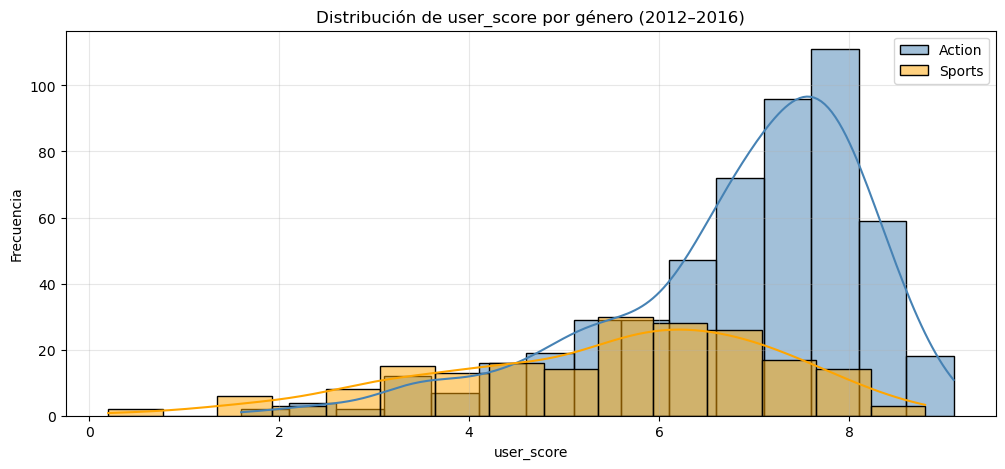

In [108]:
# Grafico de distribucion.

plt.figure(figsize=(12,5))
sns.histplot(action_scores, color='steelblue', label='Action', kde=True, bins=15)
sns.histplot(sport_scores, color='orange', label='Sports', kde=True, bins=15)
plt.title('Distribución de user_score por género (2012–2016)')
plt.xlabel('user_score')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)
plt.show()




In [109]:
# Test de normalidad (Shapiro- Wilk)

sh_action = shapiro(action_scores)
sh_sports = shapiro(sport_scores)
print(f"Shapiro Action:  W={sh_action.statistic:.3f}, p={sh_action.pvalue:.4f}")
print(f"Shapiro Sports:  W={sh_sports.statistic:.3f}, p={sh_sports.pvalue:.4f}")

Shapiro Action:  W=0.912, p=0.0000
Shapiro Sports:  W=0.969, p=0.0003


In [110]:
# Welch (paramétrico)
t_stat, p_welch = st.ttest_ind(action_scores, sport_scores, equal_var=False)

# Mann–Whitney (no paramétrico)
u_stat, p_mwu = st.mannwhitneyu(action_scores, sport_scores, alternative='two-sided')

print(f"[Welch] t = {t_stat:.3f}, p = {p_welch:.4f}")
print(f"[Mann–Whitney] U = {u_stat:.0f}, p = {p_mwu:.4f}")


[Welch] t = 9.903, p = 0.0000
[Mann–Whitney] U = 75775, p = 0.0000


### Acción vs Deportes (user_score, 2012–2016)


**Criterio de prueba**
> Las calificaciones de los usuarios (`user_score`) no siguen una distribución perfectamente normal y las varianzas pueden diferir entre géneros.  
>  
> Por ello, se aplicó el **t-test de Welch** (`st.ttest_ind(a, b, equal_var=False)`), que **no asume varianzas iguales** y es robusto ante tamaños de muestra distintos.  
>  
> Como contraste no paramétrico se aplicó el **test de Mann–Whitney U**, que **compara distribuciones sin requerir normalidad**.



**Resultados**
- Welch: t = 9.903, p = 0.0000
- Mann–Whitney: U = 75775, p = 0.0000  



**Conclusión estadística**
> Dado que ambos p-valores son menores que 0.05, **se rechaza la hipótesis nula (H₀)**.  
> Existe una **diferencia estadísticamente significativa** entre las calificaciones promedio de los géneros **Acción** y **Deportes**.  
>  
> Los resultados indican que los juegos de **Acción** presentan **calificaciones promedio más altas**, confirmando una percepción más favorable por parte de los usuarios.



**Interpretación analítica**
> En términos de negocio, los jugadores tienden a valorar mejor los títulos de Acción frente a los de Deportes.  
> Este hallazgo sugiere que el género Acción representa una **oportunidad comercial más fuerte**, especialmente para campañas de promoción o lanzamientos de alto impacto.


##  Conclusión general

###  Resumen del análisis

El estudio permitió analizar las ventas globales de videojuegos y su relación con factores como **plataforma, género, región, reseñas y clasificación ESRB**, utilizando datos históricos hasta 2016.

Tras limpiar y preparar los datos, se definió el periodo **2012–2016** como representativo para proyectar tendencias hacia 2017.

###  Principales hallazgos

- **Plataformas líderes:**  
  - **PS4** y **Xbox One** dominaron el mercado en Norteamérica y Europa.  
  - En **Japón**, prevalecen las plataformas **portátiles** como **3DS** y **PSV**, reflejando diferencias culturales en los hábitos de juego.

- **Géneros más rentables:**  
  - **Acción**, **Shooter** y **Sports** concentraron la mayoría de las ventas globales.  
  - En Japón, los jugadores mostraron preferencia por **Role-Playing (RPG)** y **Platform**, géneros más narrativos y tradicionales.

- **Clasificación ESRB:**  
  - En **NA/EU**, los títulos **M (Mature)** y **T (Teen)** concentran la mayor cuota de ventas.  
  - En **JP**, prevalecen categorías **E (Everyone)** y **T (Teen)**, más familiares y orientadas a portátiles.

- **Impacto de reseñas:**  
  - Existe una correlación positiva moderada entre las **reseñas de críticos** y las **ventas**, mientras que las reseñas de usuarios tienen una correlación débil o inexistente.  
  - Esto sugiere que la **crítica profesional** influye más en las decisiones de compra que las valoraciones individuales.

- **Pruebas de hipótesis:**  
  - **Xbox One vs PC:** no se encontraron diferencias significativas en las calificaciones promedio de usuarios.  
  - **Acción vs Deportes:** se halló una diferencia significativa (p < 0.05), con **mejores calificaciones para los juegos de Acción**.

###  Implicaciones y recomendaciones para 2017

1. **Priorizar lanzamientos multiplataforma** (especialmente en PS4, XOne y PC), ya que las valoraciones de usuarios son similares y las audiencias se superponen.  
2. **Invertir más en géneros de Acción y Shooter**, que combinan altos niveles de ventas y calificaciones positivas.  
3. **Diseñar campañas específicas por región:**
   - **NA/EU:** enfoque en consolas de sobremesa y géneros de acción competitiva.  
   - **JP:** priorizar títulos portátiles y de rol narrativo.  
4. **Colaborar con críticos y prensa especializada**, ya que las reseñas profesionales tienen un impacto directo en el rendimiento comercial.  
5. **Monitorear la clasificación ESRB**, adaptando el contenido y marketing a las sensibilidades de cada región.

###  Conclusión final

> Los resultados confirman que el **éxito comercial de un videojuego** depende de una combinación de **plataforma adecuada, género popular y recepción crítica positiva**.  
>  
> Las estrategias de publicación para 2017 deben enfocarse en **consolidar los géneros más exitosos**, **aprovechar las similitudes entre mercados occidentales** y **mantener un enfoque regionalizado** en Asia, donde las preferencias y plataformas difieren significativamente.
> Este análisis consolida un marco analítico reproducible para futuras predicciones de ventas y evaluación de títulos en desarrollo
